# Graph Neural Networks
## Graph Representation
A graph $\mathcal{G}$ is defiend as a tuple of a set of nodes/vertices $V$, and a set of edges/links $E$: $\mathcal{G} = (V,E)$. Each edge is a pair of two vertices, and represents a connection between them. For instance, let’s look at the following graph:


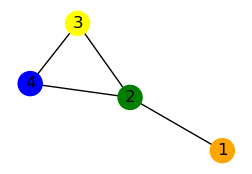

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G= nx.Graph()
G.add_nodes_from([(1,{'color':'orange'}),
                  (2,{'color':'green'}),
                  (3,{'color':'yellow'}),
                  (4,{'color':'blue'})])# V = \{1,2,3,4\}
G.add_edges_from([(1,2),(2,3),(2,4),(3,4)]) # E = \{(1,2),(2,3),(2,4),(3,4)\}
colors = [data['color'] for node, data in G.nodes(data=True)]
fig, ax = plt.subplots(figsize=(3, 2))
nx.draw(G, with_labels=True,node_color = colors)
plt.show()

In application, vertices and edge can often have specific ***attributes***, and edges can even be directed. The question is how we could represent this diversity in an efficient way for matrix operations.
Usually, for the edges, we my represent as an ***adjacency matrix***.

#### Adjacency Matrix
The adjacency matrix $A$ is a square matrix whose elements indicate whether pairs of vertices are adjacent, i.e. connected, or not. In the simplest case
$$
A_{ij} = \left\{\begin{aligned}&1, \text{ if there is a connection from node i to j};\\
&0, \text{ otherwise.} \end{aligned}\right.
$$
For an undirected graph, $A$ is a symmetric matrix($A_{ij}=A_{ji}$).
For the above example, we have 

$$
A = \left[\begin{matrix}
0&1&0&0\\
1&0&1&1\\
0&1&0&1\\
0&1&1&0
\end{matrix}\right]
$$

If we have edge attributes or different categories of edges in a graph, this information can be added to the matrix as well. 

## Graph Convolution Networks(GCNs)
Input: node features $ \mathbf{x}_i$ for node $i \in V$, adjacency matrix $A$.
Now, we study the graph convolutional layer from scratch.

In neural networks, linear layers apply a linear transformation to the incoming data. They transform input features $\mathbf{x}$ into hidden vectors $\mathbf{h}$ using a weight matrix $W$. If we ignore biases, we can write:
$$
\mathbf{h} = W\mathbf{x}
$$

With graph data, we have access to ***connections between nodes.*** Under a hypothesis that similar nodes are more likely to be connected to each other than dissimilar ones(network homophily), we can enrich the node representation by ***aggregating its features with those of its neighbors***, a.k.a. convolution or neighborhood aggregation:

$$
\mathbf{h}_i = \sum_{j \in \tilde{\mathcal{N}}_i}W\mathbf{x}_j,
$$

where $\tilde{\mathcal{N}}_i$ is the neighborhood of node $i$ including itself.

Unlike filters in Convolutional Neural Networks (CNNs), our weight matrix $W$ is unique and shared among every node. But there is another issue: nodes do not have a fixed number of neighbors like pixels do.

To address this issue, we can normalize the result based on the number of connections. In graph theory, this number is called a degree.

$$
\mathbf{h}_i = \frac{1}{\deg(i)}\sum_{j \in \tilde{\mathcal{N}}_i}W\mathbf{x}_j
$$

However, the above normalization can be ill-conditioned since the authors of GCN noticed that features from nodes with a lot of neighbors will spread much more easily than those from more isolated nodes. To counterbalance this effect, they proposed to give bigger weights to features from nodes with few neighbors. This operation can be written as follows:

$$
h_i = \sum_{j \in \tilde{\mathcal{N}}_i} \dfrac{1}{\sqrt{\deg(i)}\sqrt{\deg(j)}} \mathbf{W} x_j
$$

GCN:

$$
\mathbf{H}^{(l+1)} = \sigma(\hat{\mathbf{A}}\mathbf{H}^{(l)}\mathbf{W}^{(l)}),
$$

where $\mathbf{H}^{(l)}$ is feature embedding matrix in the $l-th$ layer;

$\sigma$ is an activation function;

$W^{(l)}$ is parameter matrix;

$\hat{\mathbf{A}} = \tilde{\mathbf{D}}^{-\frac{1}{2}}\tilde{\mathbf{A}}\tilde{\mathbf{D}}^{-\frac{1}{2}}, \tilde{\mathbf{A}} = A+I,\tilde{\mathbf{D}}^{-\frac{1}{2}} = diag(\sum_i\tilde{\mathbf{A}}_{i1},\cdots,\sum_i\tilde{\mathbf{A}}_{in})$;

$\mathbf{H}^{(0)} = \mathbf{X}.$

In [2]:
import torch.nn as nn
# A simplified version of GCN
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [3]:
# Apply GCN to our example graph
# pecify some node features and the adjacency matrix with added self-connections:
import torch
import torch.utils.data as data
import torch.optim as optim
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


In [4]:
# initialize the linear weight matrix as an identity matrix
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])
with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


One issue we can see from looking at the example above is that the output features for nodes 3 and 4 are the same because they have the same adjacent nodes (including itself). Therefore, GCN layers can make the network forget node-specific information if we just take a mean over all messages.

## Tasks on graph-structured data
### Node-level tasks: Semi-supervised node classification
Goal: Classify nodes in a graph.
Input: Usually a single, large graph with >1000 nodes of which a certain amount of nodes are labeled.

We learn to classify those labeled examples during training and try to generalize to the unlabeled nodes.

***Example:*** Cora dataset is a citation network among papers. The Cora consists of 2708 scientific publications with links between each other representing the citation of one paper by another. The task is to classify each publication into one of seven classes. Each publication is represented by a bag-of-words vector. This means that we have a vector of 1433 elements for each publication, where a $1$ at feature $i$ indicates that the $i-th$ word of a pre-defined dictionary is in the article.  

In [5]:
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
# load data
cora_dataset = torch_geometric.datasets.Planetoid(root='/Users/zoeyzhu/Desktop/', name="Cora")
CHECKPOINT_PATH = "/Users/zoeyzhu/Desktop/saved_models/gnn"

In [6]:
cora_dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [7]:
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv
}

In [8]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [9]:
class MLPModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, dp_rate=0.1):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of hidden layers
            dp_rate - Dropout rate to apply throughout the network
        """
        super().__init__()
        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                nn.Linear(in_channels, out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [nn.Linear(in_channels, c_out)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x, *args, **kwargs):
        """
        Inputs:
            x - Input features per node
        """
        return self.layers(x)

In [10]:
import PIL
from PIL import Image
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Global seed set to 42


cpu


In [11]:
class NodeLevelGNN(pl.LightningModule):

    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)
        else:
            self.model = GNNModel(**model_kwargs)
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index = data.x, data.edge_index
        x = self.model(x, edge_index)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            assert False, f"Unknown forward mode: {mode}"

        loss = self.loss_module(x[mask], data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        return loss, acc

    def configure_optimizers(self):
        # We use SGD here, but Adam works as well
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

#### Training
In the single graph, use a batch size of 1 for the data loader and share the same data loader for the train, validation, and test set.

In [12]:
import os
def train_node_classifier(model_name, dataset, **model_kwargs):
    pl.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200,
                         enable_progress_bar=False) # False because epoch size is 1
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"NodeLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything()
        model = NodeLevelGNN(model_name=model_name, c_in=dataset.num_node_features, c_out=dataset.num_classes, **model_kwargs)
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on the test set
    test_result = trainer.test(model, node_data_loader, verbose=False)
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    _, train_acc = model.forward(batch, mode="train")
    _, val_acc = model.forward(batch, mode="val")
    result = {"train": train_acc,
              "val": val_acc,
              "test": test_result[0]['test_acc']}
    return model, result

In [13]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train" in result_dict:
        print(f"Train accuracy: {(100.0*result_dict['train']):4.2f}%")
    if "val" in result_dict:
        print(f"Val accuracy:   {(100.0*result_dict['val']):4.2f}%")
    print(f"Test accuracy:  {(100.0*result_dict['test']):4.2f}%")

#### MLP for node classification

In [14]:
node_mlp_model, node_mlp_result = train_node_classifier(model_name="MLP",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)

print_results(node_mlp_result)

Global seed set to 42
/Users/zoeyzhu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/zoeyzhu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Global seed set to 42

  | Name        | T

Train accuracy: 100.00%
Val accuracy:   51.80%
Test accuracy:  58.50%


/Users/zoeyzhu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Although the MLP can ***overfit*** on the training dataset because of the high-dimensional input features, it does not perform too well on the test set.

#### 2 layer GCN for node classification

In [15]:
node_gnn_model, node_gnn_result = train_node_classifier(model_name="GNN",
                                                        layer_name="GCN",
                                                        dataset=cora_dataset,
                                                        c_hidden=16,
                                                        num_layers=2,
                                                        dp_rate=0.1)
print_results(node_gnn_result)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 23.1 K
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=200` reached.


Train accuracy: 99.29%
Val accuracy:   76.20%
Test accuracy:  81.40%


The GNN model outperforms the MLP by quite a margin. This shows that using the graph information indeed improves our predictions and lets us generalizes better.

### Graph-level tasks: Graph classification

***Goal:*** To classify an entire graph instead of single nodes or edges.

***Input:*** A dataset of multiple graphs that we need to classify based on some structural graph properties.

The most common task for graph classification is ***molecular property prediction***, in which molecules are represented as graphs. Each atom is linked to a node, and edges in the graph are the bonds between atoms.

The dataset we will use below is called the MUTAG dataset. It is a common small benchmark for graph classification algorithms, and contain ***188 graphs*** with 18 nodes and 20 edges on average for each graph. The graph nodes have 7 different labels/atom types, and the binary graph labels represent “their mutagenic effect on a specific gram negative bacterium” (the specific meaning of the labels are not too important here). 

We can load the dataset below.

In [16]:
tu_dataset = torch_geometric.datasets.TUDataset(root='/Users/zoeyzhu/Desktop/', name="MUTAG")

In [17]:
print("Data object:", tu_dataset.data)
print("Length:", len(tu_dataset))
print(f"Average label: {tu_dataset.data.y.float().mean().item():4.2f}")

Data object: Data(x=[3371, 7], edge_index=[2, 7442], edge_attr=[7442, 4], y=[188])
Length: 188
Average label: 0.66


The first line shows how the dataset stores different graphs. The nodes, edges, and labels of each graph are concatenated to one tensor, and the dataset stores the indices where to split the tensors correspondingly. 

The length of the dataset is the number of graphs we have, and the “average label” denotes the percentage of the graph with label 1. As long as the percentage is in the range of 0.5, we have a relatively balanced dataset. 

Next, we split our dataset into a training and test part. 

In [18]:
torch.manual_seed(42)
tu_dataset.shuffle()
train_dataset = tu_dataset[:150]
test_dataset = tu_dataset[150:]

In [19]:
graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=64, shuffle=True)
graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=64) # Additional loader if you want to change to a larger dataset
graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=64)

In [20]:
batch = next(iter(graph_test_loader))
print("Batch:", batch)
print("Labels:", batch.y[:10])
print("Batch indices:", batch.batch[:40])

Batch: DataBatch(edge_index=[2, 1512], x=[687, 7], edge_attr=[1512, 4], y=[38], batch=[687], ptr=[39])
Labels: tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0])
Batch indices: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])


In [21]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x


In [22]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="test")
        self.log('test_acc', acc)

In [23]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=500,
                         enable_progress_bar=False)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=tu_dataset.num_node_features,
                              c_out=1 if tu_dataset.num_classes==2 else tu_dataset.num_classes,
                              **model_kwargs)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on validation and test set
    train_result = trainer.test(model, graph_train_loader, verbose=False)
    test_result = trainer.test(model, graph_test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result

In [24]:
model, result = train_graph_classifier(model_name="GraphConv",
                                       c_hidden=256,
                                       layer_name="GraphConv",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | GraphGNNModel     | 266 K 
1 | loss_module | BCEWithLogitsLoss | 0     
--------------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.067     Total estimated model params size (MB)
/Users/zoeyzhu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:84: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/Users/zoeyzhu/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning:

In [25]:
print(f"Train performance: {100.0*result['train']:4.2f}%")
print(f"Test performance:  {100.0*result['test']:4.2f}%")

Train performance: 91.71%
Test performance:  92.11%


## References
[1].https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html#Node-level-tasks:-Semi-supervised-node-classification

[2].A Gentle Introduction to Graph Neural Networks, https://distill.pub/2021/gnn-intro/

[3].Tutorial on networkx, https://networkx.org/documentation/stable/tutorial.html

[4].PyG, https://pytorch-geometric.readthedocs.io/en/latest/

[5]. GCN, https://mlabonne.github.io/blog/intrognn/